In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import lxml
import xmltodict
import xml.etree.ElementTree as ET
import torch
import torchvision
from torchvision import transforms
from glob import glob
import os

In [5]:
# load image dataset and image annotation dataset
image_dir = "images"
annotation_xml_dir = "annotations/xmls"

# get all image files and count images we have
image_files = sorted(glob(os.path.join(image_dir, "*.jpg")))
print(f"Total Images: {len(image_files)}")

# get all the annotation files
annotation_files = sorted(glob(os.path.join(annotation_xml_dir, "*.xml"))) 
print(f"Total Annotations: {len(annotation_files)}")


Total Images: 7390
Total Annotations: 3686


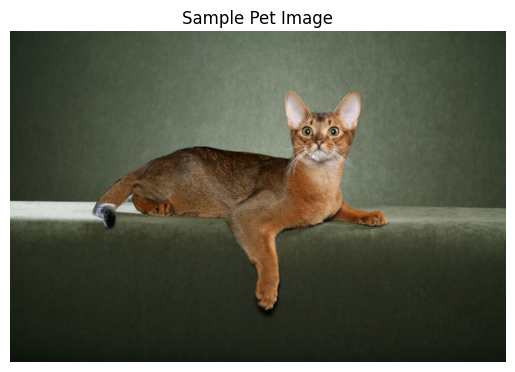

In [6]:
#grab a random image from our image files
sample_img_path = image_files[0]
img = Image.open(sample_img_path)

#display image using matplotlib
plt.imshow(img)
plt.axis("off")
plt.title("Sample Pet Image")
plt.show()

In [7]:
#define a function to parse our annotations xml dir
# and find the species of each image
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    obj = root.find("object")
    breed = obj.find("name").text
    return breed

#sample annotation 
sample_annotation_path = annotation_files[0]
breed = parse_annotation(sample_annotation_path)
print(f"Breed: {breed}")


Breed: cat


In [8]:
#create a dataframe using our image files and annotation files
data = []
for img_path, ann_path in zip(image_files, annotation_files):
    breed = parse_annotation(ann_path)
    data.append((img_path, breed))
#display a sample df
df = pd.DataFrame(data, columns=["image_path", "species"])
print(df.head())

                  image_path species
0    images/Abyssinian_1.jpg     cat
1   images/Abyssinian_10.jpg     cat
2  images/Abyssinian_100.jpg     cat
3  images/Abyssinian_101.jpg     cat
4  images/Abyssinian_102.jpg     cat


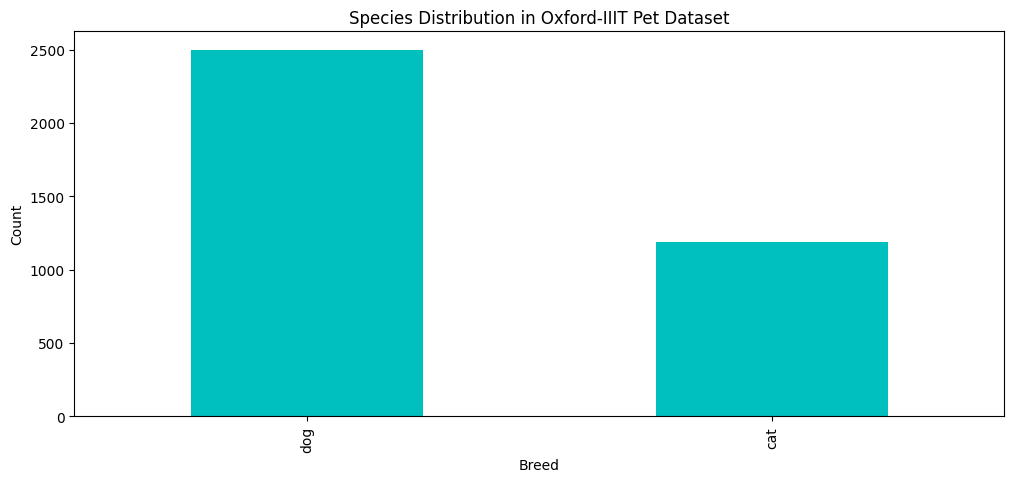

In [9]:
# create a bar graph to show the distribution of species in our pet dataset
df["species"].value_counts().plot(kind="bar", figsize=(12, 5), color="c")
plt.title("Species Distribution in Oxford-IIIT Pet Dataset")
plt.xlabel("Breed")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

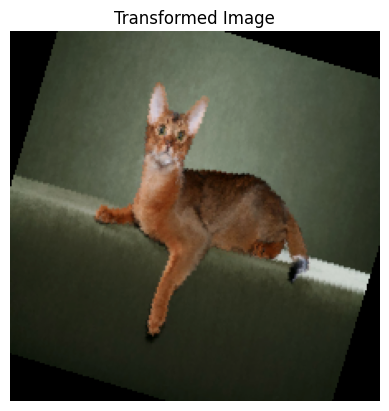

In [21]:
#transform object to uniform size and color to avoid possible discrepencies
#turn image into tensor to feed into model
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(20),  
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])
#dertransform to show sample transformation with applied changes
def transform_and_show(image_path):
    image = Image.open(image_path)
    transformed_image = train_transform(image)  # Apply transformations
    # Change dimensions (H, W, C)
    image_np = transformed_image.permute(1, 2, 0).numpy()  
    image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406] 

    image_np = image_np.clip(0, 1)

    # Display the transformed image
    plt.imshow(image_np)
    plt.axis("off")
    plt.title("Transformed Image")
    plt.show()

#choose first image
transform_and_show(image_files[0])

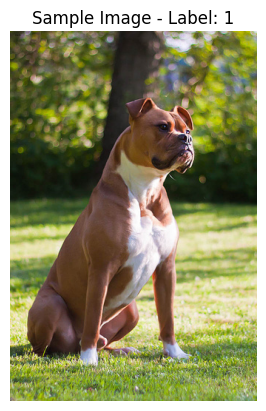

In [29]:
#prepare dataset for our model to be trained on tensors
#load dataset with transformations and create split in the data for training and evaluation
#import dataset using pytorch,NOTE:did not know the dataset was built in pytorch before downloading dataset
from torchvision.datasets import OxfordIIITPet

#load dataset from pytorch
dataset = OxfordIIITPet(root="data", split="trainval", download=True)

#load sample image from dataset
image, label = dataset[52]

#displays image
plt.imshow(image)
plt.axis("off")
plt.title(f"Sample Image - Label: {label}")
plt.show()


In [32]:
from torch.utils.data import DataLoader, random_split
#define the transformations on the evaluation portion of the dataset
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

#load dataset using transformation
 # Load the full dataset with training transforms
full_dataset = OxfordIIITPet(
    root="./data",
    split='trainval',
    download=True,
    transform=train_transform
)

# Load validation dataset with validation transforms
val_dataset_for_transform = OxfordIIITPet(
    root="./data",
    split='test',
    download=True,
    transform=val_transform
)

